<a href="https://colab.research.google.com/github/ContextLab/cs-for-psych/blob/master/slides/module_8/NLP_of_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing of movie reviews

<img src='https://hips.hearstapps.com/pop.h-cdn.co/assets/16/19/1462894749-ibm-tape-bot.gif'>

The [Internet Movie Database (IMDB)](https://en.wikipedia.org/wiki/IMDb) is an online database containing reviews, video clips, and other information about millions of movies, television shows, video games, and other media content.

In this exercise we'll be using [Natural Language Processing (NLP)](https://en.wikipedia.org/wiki/Natural_language_processing) approaches to analyze IMDB movie reviews.

The main libraries we'll be leveraging are:
  - [scikit-learn](https://en.wikipedia.org/wiki/Natural_language_processing): a machine learning library that includes implementations of some NLP models and approaches
  - [tensorflow](https://www.tensorflow.org/): a library for implementing and fitting deep learning models; here we'll be using tensorflow as an interface for loading in some pre-trained models
  - [gensim](https://radimrehurek.com/gensim/): NLP library with good (and fast!) implementations of many interesting models; also contains wrapper functions for downloading various datasets and corpora
  - [natural language toolkit (nltk)](https://www.nltk.org/): a nice library with useful tools for working with text data
  - [hypertools](hypertools.readthedocs.io/): a library with a clean API that wraps some useful scikit-learn and nltk functions; also contains tools for visualizing and manipulating high-dimensional data (like text embedding vectors!)

# Library imports (and installs)

Run the next cell first...

In [287]:
# Library imports-- take note of these aliases!
import string
import numpy as np
import pandas as pd
import sklearn as skl
import scipy as sp
import scipy.signal as signal
import tensorflow as tf
import matplotlib as mpl
import seaborn as sns
import gensim as gs
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('stopwords')

try:
  import hypertools as hyp
except ModuleNotFoundError:
  !pip install --quiet git+https://github.com/ContextLab/hypertools.git
  import hypertools as hyp

try:
  from num2words import num2words
except ModuleNotFoundError:
  !pip install --quiet num2words
  from num2words import num2words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load the datasets and wrangle them into convenient formats

You don't need to fill in any code in the cells below that loads and wrangles the dataset, but you should make sure that you understand the code and how the dataset is formatted.

## IMDB reviews

The IMDB reviews dataset is organized into a [tar file](https://en.wikipedia.org/wiki/Tar_(computing)) with the following structure (non-essential files and folders are omitted):

```
aclimdb:
├── test:
│   ├── neg
|   ├── urls_neg.txt
│   ├── pos
│   └── urls_pos.txt
└── train
    ├── neg
    ├── urls_neg.txt
    ├── pos
    └── urls_pos.txt
```

We'll be ignoring the `test` and `train` designations for this assignment (we'll create our own later; for now we'll just combine everything a merged testing and training dataset).  The `neg` and `pos` folders contain text files for each review.  Each review's text file is named using the scheme `<MOVIE_ID>_<REVIEW_ID>`, where `<MOVIE_ID>` is a non-negative integer corresponding to a unique identifier for the movie, and where `<REVIEW_ID>` is a non-negative integer corresponding to a unique identifier for each review of that movie.

The `urls_neg.txt` and `urls_pos.txt` files contain IMDB URLs for each negatively and positively reviewed movie within each subset of the data.  The URLs are listed in order of the `<MOVIE_ID>s` reflected in the reviews' text files.  Note that a given `<MOVIE_ID>` can appear in the sets of both the negative *and* positive reviews if it receives at least one negative and one positive review.

In [3]:
import os
import tarfile
import urllib.request as get
from glob import glob as lsdir
from bs4 import BeautifulSoup #super useful library for web scraping!

# fetch and extract a tarfile stored remotely
def extract_remote_tarfile(url):
  stream = get.urlopen(url)
  tf = tarfile.open(fileobj=stream, mode='r|gz')
  tf.extractall()

# load a text file and strip HTML tags
def txt_loader(fname):
  f = open(fname, 'r')
  html = f.read()
  f.close()

  soup = BeautifulSoup(html)
  return soup.get_text()

In [4]:
# fetch and extact the IMDB dataset.
# This creates a new folder, aslImdb, under the current working directory.

imdb_url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
extract_remote_tarfile(imdb_url)
imdb_root = 'aclImdb'

In [5]:
# organize the IMDB dataset
def load_imdb_dir(root, labels):
  parse_movie_id = lambda f: int(os.path.split(f)[1].split('_')[0])
  parse_review_id = lambda f: int(os.path.split(f)[1].split('_')[1][:-4])
  parse_imdb_id = lambda url: url.split('/')[-1]

  data = {'review': [], 'url': [], 'rating': [], 'review ID': [], 'IMDB ID': [], 'file': []}

  for label in labels:
    #text of reviews
    review_fnames = lsdir(os.path.join(root, label, '*.txt'))
    data['review'].extend([txt_loader(r) for r in review_fnames])
    data['file'].extend(review_fnames)

    #ratings (label)
    data['rating'].extend([label] * len(review_fnames))

    #movie ID and review ID
    movie_ids = [parse_movie_id(r) for r in review_fnames]
    data['review ID'].extend([parse_review_id(r) for r in review_fnames])

    #add urls
    url_key = txt_loader(os.path.join(root, f'urls_{label}.txt')).split('\n')
    urls = [url_key[i][:-len('/usercomments')] for i in movie_ids]
    data['url'].extend(urls)

    #IMDB ID
    data['IMDB ID'].extend([parse_imdb_id(u) for u in urls])
  
  df = pd.DataFrame.from_dict(data)
  df.set_index(['IMDB ID', 'review ID'], inplace=True)
  return df

In [6]:
# load and organize the IMDB dataset (and remove train/text designations)
training_data = load_imdb_dir(os.path.join('aclImdb', 'train'), labels=['pos', 'neg'])
test_data = load_imdb_dir(os.path.join('aclImdb', 'test'), labels=['pos', 'neg'])
imdb_data = pd.concat([training_data, test_data])

Now let's take a look at the organized dataset-- our DataFrame is indexed by each film's IMDB identifier (`IMDB ID`) and review ID (`review ID`).

In [7]:
imdb_data.head(10)

,,review,url,rating,file
IMDB ID,review ID,,,,
tt0486655,9,I went to a small advance screening of this mo...,http://www.imdb.com/title/tt0486655,pos,aclImdb/train/pos/635_9.txt
tt0040871,10,This a Casper the Friendly Ghost short from my...,http://www.imdb.com/title/tt0040871,pos,aclImdb/train/pos/2430_10.txt
tt0248928,9,"Excellent movie, a realistic picture of contem...",http://www.imdb.com/title/tt0248928,pos,aclImdb/train/pos/3235_9.txt
tt0174360,8,A meltdown at a nuclear power plant causes a m...,http://www.imdb.com/title/tt0174360,pos,aclImdb/train/pos/5768_8.txt
tt0239921,9,I saw this film when I was a young child on te...,http://www.imdb.com/title/tt0239921,pos,aclImdb/train/pos/8973_9.txt
tt0228979,10,Very Slight Spoiler This movie (despite being ...,http://www.imdb.com/title/tt0228979,pos,aclImdb/train/pos/3472_10.txt
tt0485601,10,First animated feature film from Ireland is al...,http://www.imdb.com/title/tt0485601,pos,aclImdb/train/pos/11658_10.txt
tt0382330,9,"This film, recently voted as an audience favor...",http://www.imdb.com/title/tt0382330,pos,aclImdb/train/pos/6465_9.txt
tt0114057,10,Students often ask me why I choose this versio...,http://www.imdb.com/title/tt0114057,pos,aclImdb/train/pos/6075_10.txt


We can also view the text of a sample review (we'll use the `pprint` library to deal with text wrapping so that the review is formatted in a readable way):

In [8]:
from pprint import PrettyPrinter

random_review = np.random.randint(imdb_data.shape[0])
pp = PrettyPrinter()
pp.pprint(imdb_data.iloc[random_review]['review'])

('For the record, this film is intriguing but its hardly original. Back in '
 '1998 a movie starring Talia Shire called The Landlady had almost the exact '
 'same plot but with younger characters.The story is Amanda Lear has had a bad '
 "life, abusive father, horny doctor, mental homes, etc. She's finally "
 'released from the happy home under the guidance of her perverted '
 'doctor...who she anally abuses and kills the poor guy. (now THAT was '
 'original) The doctor had financed a mansion for her before she killed him '
 'and buried the sucker in the backyard. After moving in she falls in love '
 'with a stud named Richard, who just happens to be married to a blues singer. '
 "If you've seen The Landlady you know the rest, she kills or tries to kill "
 'anyone that gets in between her and Richard (including a roadie).Much of the '
 "idea's came from the previous movie, same idiot sidekick that sticks his "
 'nose in, same spying on the guy with a bowl of popcorn, same flying a '
 '

# What's the *goal* of natural language processing?

The fundamental goal of NLP approaches to analyzing text is to use heuristics, data processing algorithms, and models to extract or characterize the conceptual content of text data.

In practice, this can mean many things.  For the purposes of today's exercise, we'll "characterize the conceptual content" by using [text embedding models](https://en.wikipedia.org/wiki/Word_embedding).  The idea is to turn a *document* (i.e., some text) into a *feature vector* (i.e., a sequence of numbers).  Ideally, the feature vectors for documents that are conceptually related will be similar to each other (e.g., nearby in Euclidean distance, correlated, etc.).  In other words, text embedding models define a [geometric space](https://en.wikipedia.org/wiki/Space) such that each point in the space corresponds to some concept, and nearby points correspond to similar concepts.

There are *many* other interesting and useful approaches to natural language processing that we will not cover, including (but not limited to):
- Generating [parse trees](https://en.wikipedia.org/wiki/Parse_tree)
- [Sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis)
- [Automatic summarization](https://en.wikipedia.org/wiki/Automatic_summarization)
- [Semantic search](https://en.wikipedia.org/wiki/Semantic_search)

# Preprocessing

Models vary substantially in how well they're able to handle "raw" (unprocessed) data.  In general, though, most models benefit from some basic preprocessing steps.  A detailed overview of text preprocessing in the context of topic modeling (one type of word embedding model) is provided in Section 1.2.2 of the excellent book chapter, [Care and Feeding of Topic Models](https://home.cs.colorado.edu/~jbg/docs/2014_book_chapter_care_and_feeding.pdf).  It's worth reading the full chapter if you want to dig deeper into text embedding models.

The fundamental goals of preprocessing text data are the same as when we preprocess other types of data.  For example:
- We want to remove formatting strangeness (e.g., data corruption, strange characters, HTML tags, perhaps punctuation, spelling errors, etc.) that could trip us up when we apply pattern matching
- We want to remove the differences (between words, observations, documents, etc.) that don't carry meaning we care about while preserving differences that we do care about

Unfortunately, there are no universal rules in text preprocessing.  However, it's usually useful to take a few basic steps to "clean up" your raw text data before running it through text embedding models. In a "real" application, it'd be useful to do some careful analyses of how each preprocessing step affects your results and/or subsequent steps of your analysis pipeline.  However, here our main goal is to get you up and running quickly, so we'll skip most of that pesky "due diligence" stuff.

Next, we'll use the NLTK library to implement two basic preprocessing steps:
1. [Lemmatization](https://en.wikipedia.org/wiki/Lemmatisation): equate all inflected verbs, pluralized nouns, etc. by turning different "forms" of the same word into text with the same letters.  For example, "walk", "walking", "walks", and "walked" should all be converted into the base form of the verb ("walk").
2. [Stop word](https://en.wikipedia.org/wiki/Stop_word) removal: stop words are words that are "devoid of semantic meaning" such as "and", "or", "the", "but", and so on.  Although these words are often grammatically useful, they can confuse many text embedding models.

We'll also implement a third preprocessing step to:
3. Remove all punctuation, and to spell out all numbers.

In [55]:
#decorator that extends a function to apply either to a single value
#(e.g., a string), or to each element in a list
def list_generalizer(f):
  def wrapped(*args, **kwargs):
    if type(args[0]) in [np.array, np.ndarray, list]:
      return [f(*[a, *args[1:]], **kwargs) for a in args[0]]
    
    return f(*args, **kwargs)
  
  return wrapped

In [56]:
@list_generalizer
def lemmatize(text):
  def tag_to_pos(tag):
    x = {'n': ['NN', 'NNP', 'NNPS', 'NNS'],        #noun
         'r': ['RB', 'RBR', 'RBS'],                #adverb
         'v': ['VBD', 'VBG', 'VBN', 'VBP', 'VBZ'], #verb
         'a': ['JJ', 'JJR', 'JJS']}                #adjective
    
    for key, vals in x.items():
      if tag in vals:
        return key
    return 'n' #default: treat as "noun"

  lemmatizer = nltk.stem.WordNetLemmatizer()
  words = nltk.word_tokenize(text)
  tagged_words = nltk.pos_tag(words)

  return ' '.join([lemmatizer.lemmatize(w.lower(), pos=tag_to_pos(p)) for w, p in tagged_words])

In [59]:
#example
pp.pprint(lemmatize(imdb_data.iloc[random_review]['review']))

('for the record , this film be intrigue but it hardly original . back in 1998 '
 'a movie star talia shire call the landlady have almost the exact same plot '
 'but with young characters.the story be amanda lear have have a bad life , '
 "abusive father , horny doctor , mental home , etc . she 's finally release "
 'from the happy home under the guidance of her perverted doctor ... who she '
 'anally abuse and kill the poor guy . ( now that be original ) the doctor '
 'have finance a mansion for her before she kill him and bury the sucker in '
 'the backyard . after move in she fall in love with a stud name richard , who '
 "just happen to be marry to a blue singer . if you 've see the landlady you "
 'know the rest , she kill or try to kill anyone that get in between her and '
 "richard ( include a roadie ) .much of the idea 's come from the previous "
 'movie , same idiot sidekick that stick his nose in , same spy on the guy '
 'with a bowl of popcorn , same fly a bodypress . it do 

In [60]:
@list_generalizer
def filter_stopwords(text, language='english'):  
  words = nltk.word_tokenize(text)
  return ' '.join(w.lower() for w in words if w.lower() not in nltk.corpus.stopwords.words(language))

In [61]:
#example
pp.pprint(filter_stopwords(imdb_data.iloc[random_review]['review']))

('record , film intriguing hardly original . back 1998 movie starring talia '
 'shire called landlady almost exact plot younger characters.the story amanda '
 "lear bad life , abusive father , horny doctor , mental homes , etc . 's "
 'finally released happy home guidance perverted doctor ... anally abuses '
 'kills poor guy . ( original ) doctor financed mansion killed buried sucker '
 'backyard . moving falls love stud named richard , happens married blues '
 "singer . 've seen landlady know rest , kills tries kill anyone gets richard "
 "( including roadie ) .much idea 's came previous movie , idiot sidekick "
 'sticks nose , spying guy bowl popcorn , flying bodypress . original material '
 ", beer bottle thing brutal . highlight movie amanda 's beautiful breasts "
 'hot-top scene . somewhat ripoff total waste time.4 10')


In [62]:
@list_generalizer
def standardize(text):  
  words = nltk.word_tokenize(text)

  #lowercase and remove punctuation
  words = [w.lower() for w in words if w not in string.punctuation]

  #convert numbers to text
  x = []
  for w in words:
    try:
      x.append(num2words(w))
    except:
      x.append(w)
  
  return ' '.join(x)

In [63]:
pp.pprint(standardize(imdb_data.iloc[random_review]['review']))

('for the record this film is intriguing but its hardly original back in one '
 'thousand, nine hundred and ninety-eight a movie starring talia shire called '
 'the landlady had almost the exact same plot but with younger characters.the '
 'story is amanda lear has had a bad life abusive father horny doctor mental '
 "homes etc she 's finally released from the happy home under the guidance of "
 'her perverted doctor ... who she anally abuses and kills the poor guy now '
 'that was original the doctor had financed a mansion for her before she '
 'killed him and buried the sucker in the backyard after moving in she falls '
 'in love with a stud named richard who just happens to be married to a blues '
 "singer if you 've seen the landlady you know the rest she kills or tries to "
 'kill anyone that gets in between her and richard including a roadie .much of '
 "the idea 's came from the previous movie same idiot sidekick that sticks his "
 'nose in same spying on the guy with a bowl of 

# Embedding text

To help us organize our code, we'll write a wrapper function that takes in raw text and:
  - Applies a list of specified preprocessing steps (i.e., a list of functions)
  - Fits a model to the preprocessed text (if needed) using a specified function
  - Optionally applies a second set of functions to the text
  - Applies the fitted model to the newly processed text (i.e., "transforms" the text)
  - Optionally applies a final set of functions to the text embeddings
  - Returns the embeddings

Later, we'll see why this is useful...


In [215]:
def embed(text, preprocess=[], fit=None, postprocess=[], transform=None, finalize=[]):
  def apply(x, funcs):
    for f in funcs:
      x = f(x)
    return x

  #preprocessing
  if len(preprocess) > 0:
    print('pre-processing...')
  text = apply(text, preprocess)
  
  #fit model  
  if fit is not None: #fit function should return a model object
    print('fitting model...')
    model = fit(text)
  else:
    model = text
  
  #postprocessing
  if len(postprocess) > 0:
    print('post-processing...')
  text = apply(text, postprocess)
  
  #transform (apply the model)  
  if transform is not None: #apply function should return text embeddings, given the fitted model.  text may be a single string or a list/array of strings.
    print('applying model...')
    embeddings = transform(text, model)
  else:
    embeddings = model
  
  #finalize the embeddings
  if len(finalize) > 0:
    print('finalizing...')
  embeddings = apply(embeddings, finalize)
  
  return embeddings

# Example: Latent Dirichlet Allocation

Topic modeling, or [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) describes each document as a mix of "topics" (themes).  Each topic is defined as a "distribution over words in the vocabulary."  For example, if we define our vocabulary as the set of all $n$ English words, then a "topic" would comprise a set of $n$ non-negative weights that summed to 1.  A topic about neuroscience might place more weight on words like "neuron", "nerve", and "brain", whereas a topic about art might place more weight on words like "artist", "paint", and "creative".

LDA takes as input a number-of-documents by number-of-words word count matrix (i.e., the number of times each word appears in each document) and returns a number-of-documents by $k$ embeddings matrix (where $k$ is the number of topics).

We'll use the [scikit-learn implementation of LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html).  To do this, we'll need:
- A list of preprocessing functions to lemmatize the document(s), remove stop words, remove punctuation, spell out numbers, and derive a word count matrix.  Most of these are already provided above; the only "new" function we'll need to write is one that will convert a set of documents (list of strings) to a word count matrix.
- A function for fitting LDA to a set of documents' word counts and returning the fitted model.
- A function for embedding text using a fitted model.


In [216]:
#given a set of documents, get a word count matrix
def wordcounts(docs, **kwargs):
  cv = skl.feature_extraction.text.CountVectorizer(**kwargs)
  return cv.fit(docs)

In [245]:
#given a word counts matrix, return the fitted model
def lda_fit(docs, k=25, learning_method='online', learning_offset=50, max_iter=5):
  wc = wordcounts(docs, max_df=0.5, min_df=0.1, max_features=k*100)
  model = skl.decomposition.LatentDirichletAllocation(n_components=k,
                                                      learning_method=learning_method,
                                                      learning_offset=learning_offset,
                                                      max_iter=max_iter)
  model.fit(wc.transform(docs))
  return {'lda': model, 'countvec': wc}

In [246]:
#given a fitted LDA model and some (new) documents, get the documents' topic vectors
@list_generalizer
def lda_transform(docs, model):
  if type(docs) == str:
    docs = [docs]
  wc = model['countvec'].transform(docs)
  return model['lda'].transform(wc)

Now we can use the `embed` function to put everything together:

In [317]:
docs = imdb_data['review'].values
inds = np.random.choice(len(docs), size=100, replace=False)
mini_docs = docs[inds] #something that can run relatively quickly (good for testing)
mini_ratings = imdb_data.iloc[inds]['rating'].values

In [318]:
topic_embeddings = embed(mini_docs, preprocess=[lemmatize, filter_stopwords, standardize], fit=lda_fit, transform=lda_transform)

pre-processing...
fitting model...
applying model...


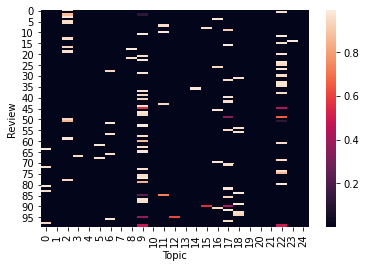

In [319]:
sns.heatmap(np.vstack(topic_embeddings))
ax = mpl.pyplot.gca()
ax.set_xlabel('Topic')
ax.set_ylabel('Review');

We can also use hypertools to color reviews by valence (positive or negative).  Here each dot corresponds to one review, and the colors reflect the associated ratings (**pos**itive  or **neg**ative).

/usr/local/lib/python3.7/dist-packages/hypertools/plot/plot.py:509: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  kwargs[kwarg]=np.array(kwargs[kwarg])


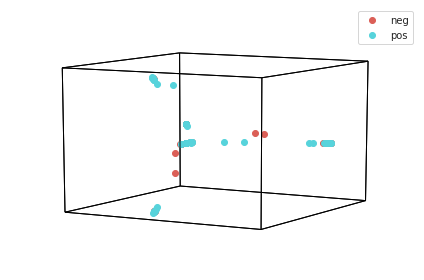

In [320]:
hyp.plot(topic_embeddings, 'o', hue=mini_ratings, legend=np.unique(mini_ratings).tolist());

## Topic *trajectories*

The above analyses treat each review as a single document.  However, each review may also have a "narrative flow" whereby different parts of the review potentially reflect different topics.

We can use the `postprocess` and `finalize` flags of the `embed` function to (a) turn each document into a *sequence* of documents (using sliding windows of $n$ words each) and (b) re-organize the embeddings of the windows as a number-of-windows by $k$ (number of topics) matrix.  In other words, each review's matrix will reflect how the conceptual content of the review changes over the course of the review.  This general approach was developed by [Heusser et al. (2021)](https://www.nature.com/articles/s41562-021-01051-6).

In [321]:
#given a single string, return a list of sub-strings (of n words each)
@list_generalizer
def sliding_window(text, n=5):
  words = nltk.word_tokenize(text)
  windows = []
  for i in range(len(words) - n):
    windows.append(' '.join(words[i:(i + n)]))
  return windows

In [322]:
vstack = lambda x: [np.vstack(i) for i in x]

def resample_and_smooth(data, n=250, wsize=51, order=3, min_val=0):
  if type(data) == list:
    return [resample_and_smooth(d, n=n, wsize=wsize, order=order, min_val=min_val) for d in data]
  
  data_resampled = np.zeros([n, data.shape[1]])
  x = np.arange(data.shape[0])
  xx = np.linspace(0, np.max(x), num=n)

  for i in range(data.shape[1]):
    data_resampled[:, i] = signal.savgol_filter(sp.interpolate.pchip(x, data[:, i])(xx), wsize, order)
    data_resampled[:, i][data_resampled[:, i] < min_val] = min_val
  return data_resampled

In [323]:
dynamic_topic_embeddings = embed(mini_docs, preprocess=[lemmatize, filter_stopwords, standardize], fit=lda_fit, transform=lda_transform, postprocess=[sliding_window], finalize=[vstack, resample_and_smooth])

pre-processing...
fitting model...
post-processing...
applying model...
finalizing...


Let's take a look at the dynamic content of some sample reviews:

In [324]:
def plot_topic_trajectory(embeddings, *args, **kwargs):
  scale = 5
  fig = mpl.pyplot.figure(figsize=(2*scale, scale))

  #heatmap
  ax1 = fig.add_subplot(1, 2, 1)
  mpl.pyplot.axes(ax1)  
  sns.heatmap(embeddings)
  ax1.set_xlabel('Topics')
  ax1.set_xlabel('Time')

  #trajectory
  ax2 = fig.add_subplot(1, 2, 2, projection='3d')
  hyp.plot(embeddings, ax=ax2, *args, **kwargs);

  return fig, ax

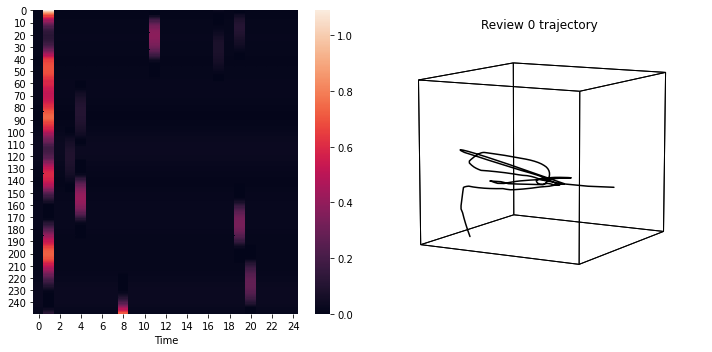

In [325]:
plot_topic_trajectory(dynamic_topic_embeddings[0], 'k', title='Review 0 trajectory');

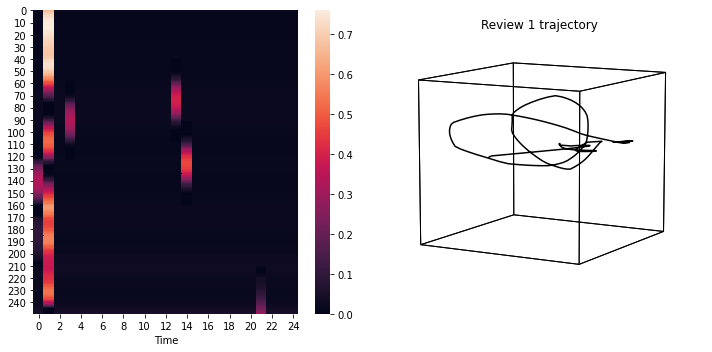

In [326]:
plot_topic_trajectory(dynamic_topic_embeddings[1], 'k', title='Review 1 trajectory');

At this point in our analysis pipeline, each movie review has been transformed into a geometric "shape" (a path through word embedding space) that reflects how its conceptual content changes over the course of the review.

Now we can ask questions about how the shapes of different reviews reflect different properties of interest.  For example, controlling for the particular content of each review, do different reviews share particular structures?

To test this, we'll use [hyperalignment](https://elifesciences.org/articles/56601) to rotate, reflect, scale, and translate the shapes of every review.  This effectively "normalizes" for the conceptual content of the different reviews, because it breaks the associations between specific dimensions and specific topics.  In other words, let's suppose that Review A discussus Topic 1, followed by Topic 2, followed by Topic 1 again.  And let's suppose that Review B discusses Topic 3, then Topic 4, and then Topic 3 again.  If we abstract away the topic labels, both of these reviews follow the same sort of "back and forth" structure.  More generally, reviews tend to follow more complicated paths involving blends of topics that change over time.

We can use hypertools to hyperalign all of the trajectories, project them into a shared 3D space:



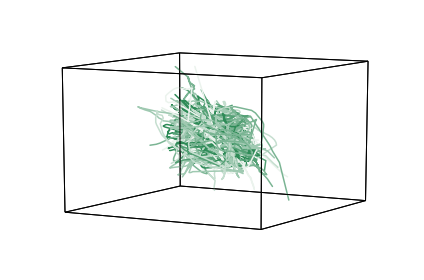

In [352]:
n_iter = 5

aligned = hyp.reduce(dynamic_topic_embeddings, reduce='UMAP', ndims=3)
for i in range(n_iter):
  aligned = hyp.align(aligned, align='hyper')

hyp.plot(aligned, reduce='UMAP', palette=sns.light_palette('seagreen'));

# Applying alternative text embedding models to the dataset

You can "swap out" Latent Dirichlet Allocation for any other text embedding model by writing analogs of the `lda_fit` and `lda_transform` functions:
- Your `fit` function should take in a set of documents (a list of strings) and return a fitted model.  The model can be of any datatype.  For pre-trained models, you just need to load in (or download) the model and then return it (e.g., you can potentially ignore the documents).
- Your `transform` function should take in a (potentially new) set of documents (again, a list of strings) and the fitted model (returned by your `fit` function).  You should return the text embeddings of the documents as a number-of-documents by number-of-features numpy array.

Some models you might find interesting include:
- [word2vec](https://en.wikipedia.org/wiki/Word2vec): a model that attempts to preserve geometric relations between words.  For example, subtracting the embedding for "man" from that of "king" and then adding the embedding for "woman" results in a new embedding vector that is similar to the embedding for "queen."  The [gensim](https://radimrehurek.com/gensim/models/word2vec.html) library includes an implementation of word2vec.
- [universal sentence encoder (USE)](https://en.wikipedia.org/wiki/Sentence_embedding): a model that attempts to capture the local (sentence-level) contexts in which words are used. The [tensorflow](https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder) library includes an implementation of USE.
- [Bidirectional Transformers (BERT)](https://github.com/google-research/bert): a model that is first pre-trained on a large text corpus, but can be fine-tuned to a new (usually smaller) dataset.  The [tensorflow](https://github.com/google-research/bert) library includes an implementation of BERT.
- [Generative Pre-trained Transformer 2 (GPT-2)](https://en.wikipedia.org/wiki/GPT-2): a huge pre-trained model that can be fine-tuned (like BERT) to a new dataset.  The [hugging face](https://huggingface.co/gpt2?text=A+long+time+ago%2C+) library contains an implementation of GPT-2.

In general, [gensim](https://radimrehurek.com/gensim/), [tensorflow](https://www.tensorflow.org/), [pytorch](https://pytorch.org/), and [hugging face](https://github.com/huggingface/transformers) libraries collectively include most popular word embedding models.

# Follow-up ideas:
- Try changing the sliding window width.  How do the results change and why?
- Look at the word embeddings for a few of the above models.  How might you explore which aspects of the data different models are picking up on?  How might you compare how "good" different models are?
- Try formulating some hypotheses about the data and test them using different text embedding models.